In [3]:
!pip install stargazer matplotlib seaborn

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from stargazer.stargazer import Stargazer
from scipy.stats import kstest, norm
import statsmodels.api as sm
from scipy.stats import f

In [5]:
df = pd.read_csv('/content/winequalityN.csv')
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


<center>
<img src="https://i.ytimg.com/vi/WUS34ngxjy0/maxresdefault.jpg" height="300">

</center>

# Описание признаков:

Независимые переменные (физико-химические характеристики):
1.	Тип вина: красное/белое (дамми: 1 если красное, 0 - иначе)
2.	Фиксированная кислотность: Основная кислотность, которая остаётся неизменной после брожения.
3.	Летучая кислотность: Уровень летучих кислот, которые могут влиять на вкус и запах.
4.	Лимонная кислота: Присутствует в небольших количествах, добавляет свежести вину.
5.	Остаточный сахар: Количество сахара, оставшегося после завершения брожения.
6.	Хлориды: Количество хлоридов, влияющее на солёность вина.
7.	Свободный диоксид серы: Концентрация свободного SO₂, который предотвращает окисление.
8.	Общий диоксид серы: Сумма всех форм SO₂.
9.	Плотность: Зависит от содержания сахара и спирта.
10.	pH: Уровень кислотности вина.
11.	Сульфаты: Влияют на антиоксидантные свойства и вкус.
12.	Спирт: Содержание алкоголя в вине.

Зависимая переменная:
13.	Качество: Органолептическая оценка вина в диапазоне от 0 до 10, определяемая экспертами.

#Предобработочка

In [6]:
df.isnull().sum()

,0
type,0
fixed acidity,10
volatile acidity,8
citric acid,3
residual sugar,2
chlorides,2
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,9


пропусков мало, так что удалим их:

In [7]:
df = df.dropna()

In [8]:
df.duplicated().sum()

1168

дубликатов много и они не помогут нам в исследовании зависимостей, так что удалим их:

In [9]:
df=df.drop_duplicates()
df.shape

(5295, 13)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5295 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  5295 non-null   object 
 1   fixed acidity         5295 non-null   float64
 2   volatile acidity      5295 non-null   float64
 3   citric acid           5295 non-null   float64
 4   residual sugar        5295 non-null   float64
 5   chlorides             5295 non-null   float64
 6   free sulfur dioxide   5295 non-null   float64
 7   total sulfur dioxide  5295 non-null   float64
 8   density               5295 non-null   float64
 9   pH                    5295 non-null   float64
 10  sulphates             5295 non-null   float64
 11  alcohol               5295 non-null   float64
 12  quality               5295 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 579.1+ KB


Все признаки числовые кроме переменной type, закодируем ее:

In [11]:
df['type'] = df['type'].map({'white': 0, 'red': 1})
df.head()

<ipython-input-11-35c9573e7bca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'] = df['type'].map({'white': 0, 'red': 1})


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
6,0,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6


# Гипотезы:

**Гипотеза 1:**
Увеличение содержания алкоголя в вине положительно влияет на оценку качества.
Обоснование: Алкоголь является одним из ключевых факторов, определяющих насыщенность вкуса и ароматическую структуру вина. Более высокое содержание алкоголя часто ассоциируется с улучшением вкусового профиля, особенно для красных вин.

**Гипотеза 2:**
Высокая летучая кислотность отрицательно влияет на оценку качества вина.
Обоснование:  В статье Correlating Wine Quality Indicators to Chemical and Sensory Measurements отмечается, что летучая кислотность указывает на наличие уксусной кислоты и других кислот, которые могут сигнализировать о дефектах производства или порче вина. Это негативно отражается на вкусовых свойствах и снижает общую оценку. [2]

**Гипотеза 3:**
Остаточный сахар положительно влияет на качество белых вин, но имеет слабую или отрицательную связь с качеством красных вин.
Обоснование: Исследователи в статье Measuring Wine Quality and Typicity обсуждают сахар, фактор влияющий на качество вина. На основании этого мы хотим проверить эту гипотезу. Для белых вин небольшой уровень остаточного сахара может улучшить восприятие вкуса, добавляя сбалансированную сладость. Однако для сухих красных вин сладость может восприниматься как недостаток и снижать оценку.[3]


<center>
<img src="https://i.pinimg.com/736x/22/38/f5/2238f5af06be2fcf6e82b5cceb7f723f.jpg" height="400">

</center>

# Анализ данных с визуализацией:

In [12]:
df_describe = df.describe()
df_describe

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,5295.000000,5295.000000,5295.000000,5295.000000,5295.000000,5295.000000,5295.000000,5295.000000,5295.000000,5295.000000,5295.000000,5295.000000,5295.000000
mean,0.255524,7.218008,0.344021,0.318782,5.051029,0.056690,30.046837,114.118225,0.994536,3.224385,0.533199,10.550154,5.796034
std,0.436197,1.320690,0.168237,0.147112,4.500641,0.036901,17.827151,56.787187,0.002969,0.160155,0.149851,1.186533,0.880005
min,0.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,0.000000,6.400000,0.230000,0.240000,1.800000,0.038000,16.000000,74.000000,0.992200,3.110000,0.430000,9.500000,5.000000
50%,0.000000,7.000000,0.300000,0.310000,2.700000,0.047000,28.000000,116.000000,0.994670,3.210000,0.510000,10.400000,6.000000
75%,1.000000,7.700000,0.410000,0.400000,7.500000,0.066000,41.000000,154.000000,0.996780,3.330000,0.600000,11.400000,6.000000
max,1.000000,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### Анализ вещественных признаков:

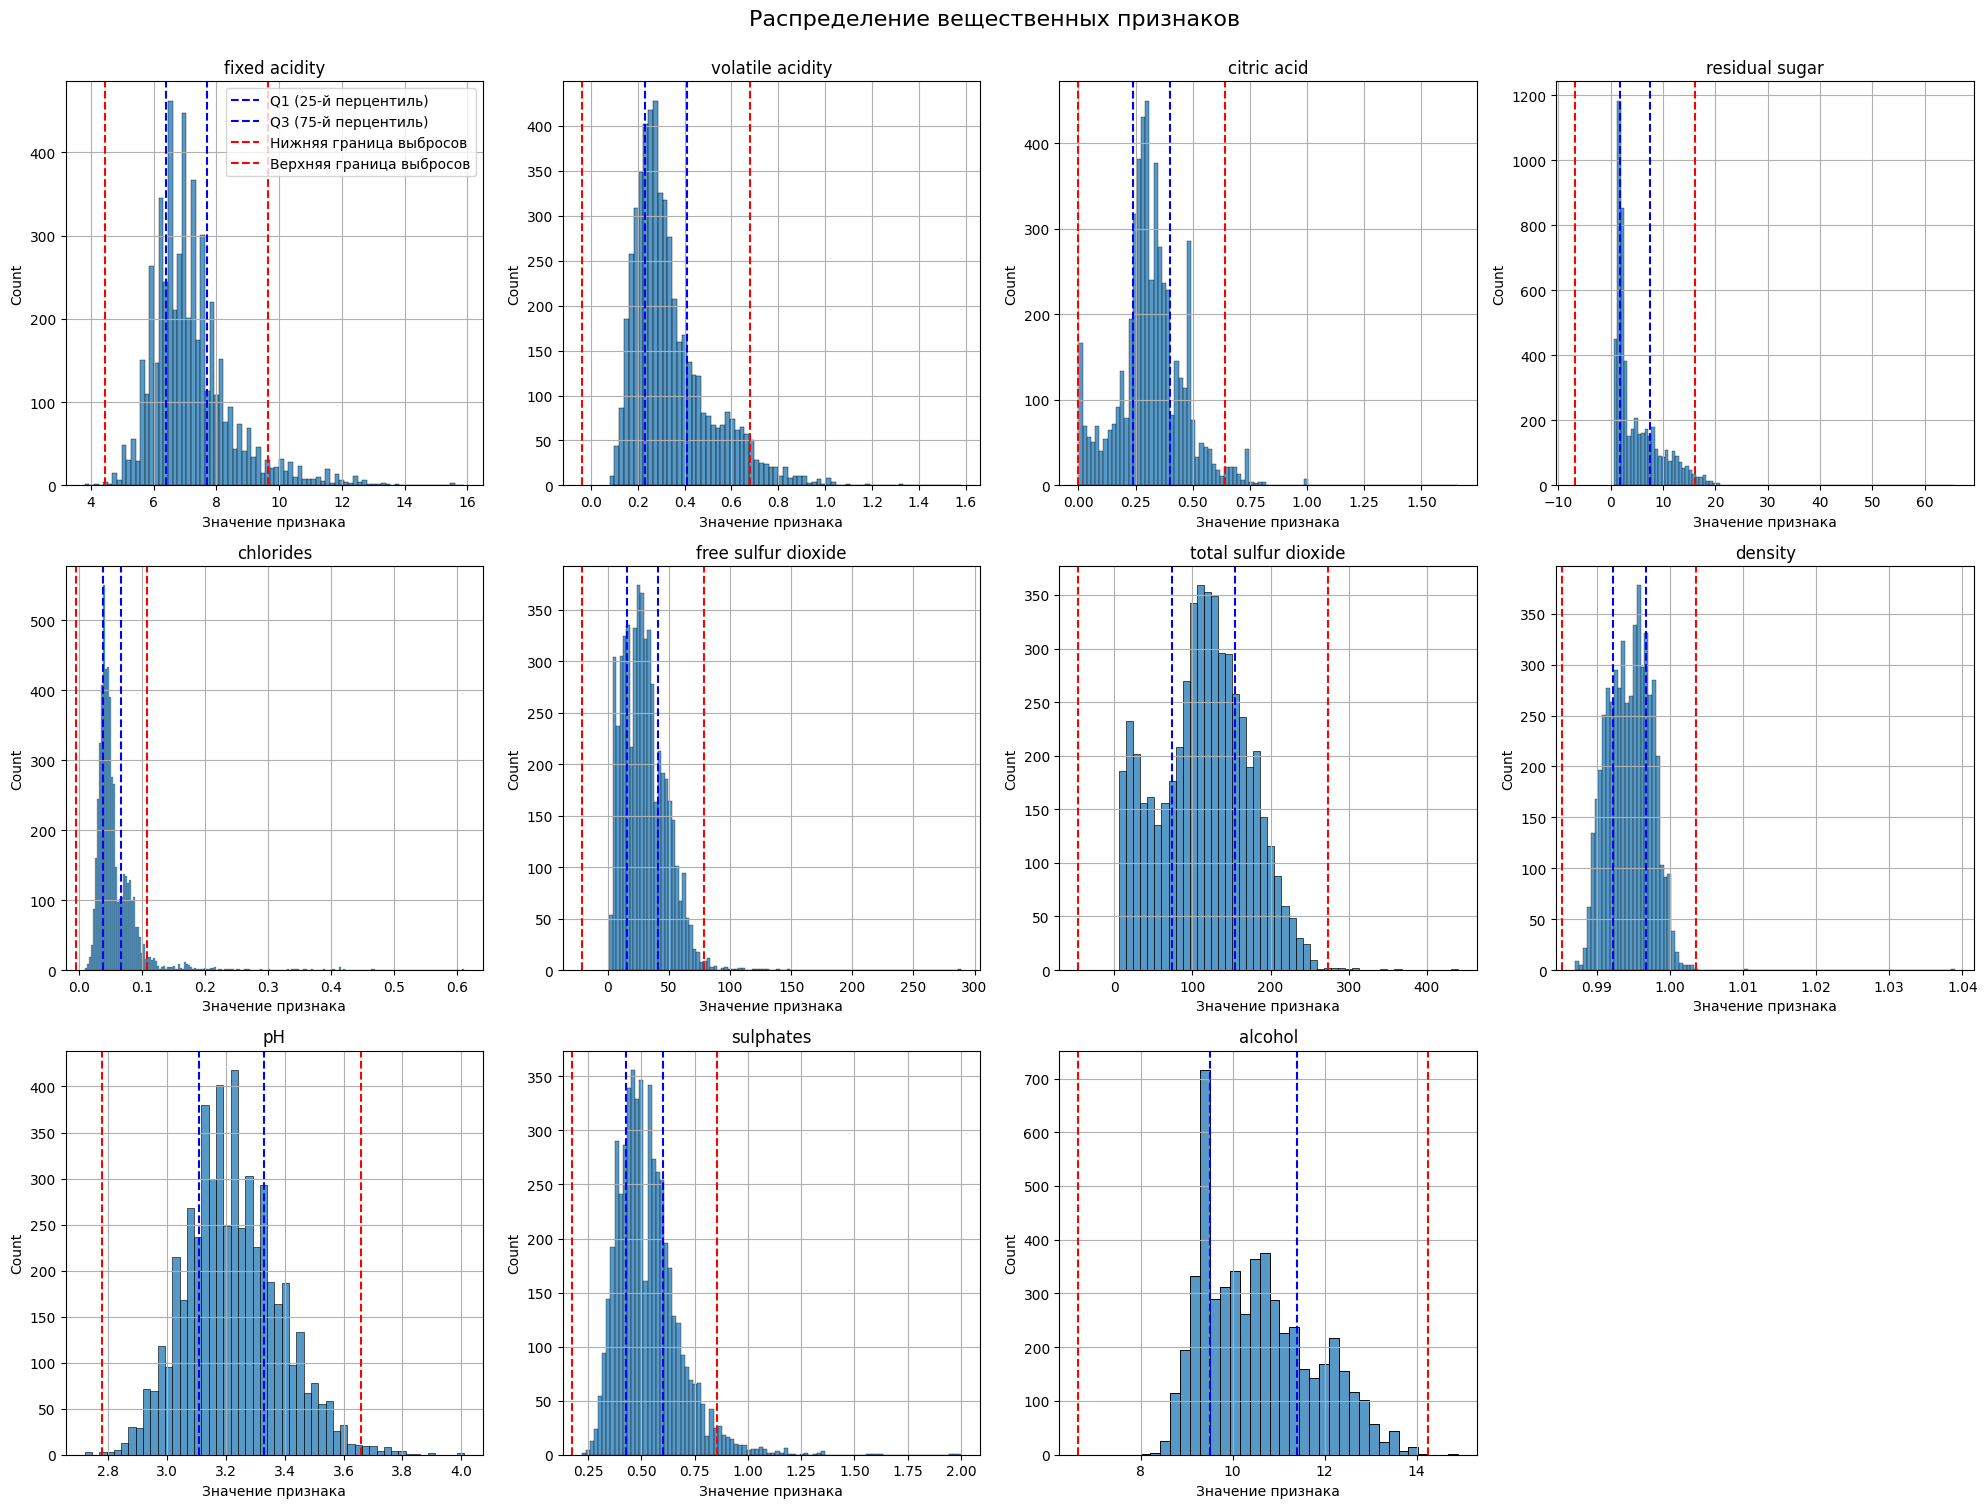

In [13]:
plt.figure(figsize=(20, 27))
plt.suptitle('Распределение вещественных признаков', y=0.9, fontsize=16)

num = 0
for column in df.select_dtypes(include=['float']).columns:
    # считаем количество выбросов
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1 # межквартильный размах
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    num_outliers = len(outliers)

    # смотрим на распределение
    ax = plt.subplot(5, 4, num + 1)
    sns.histplot(x=df[column], ax=ax)
    ax.set_title(column)
    ax.set_xlabel('Значение признака')
    # ax.text(
    #     0.95,
    #     0.95,
    #     f'Выбросы: {num_outliers}',
    #     fontsize=10,
    #     color='red',
    #     ha='right',
    #     transform=ax.transAxes
    # )

    # отметим границы квартилей и разброса
    ax.axvline(Q1, color='blue', linestyle='--', label='Q1 (25-й перцентиль)')
    ax.axvline(Q3, color='blue', linestyle='--', label='Q3 (75-й перцентиль)')
    ax.axvline(lower_bound, color='red', linestyle='--', label='Нижняя граница выбросов')
    ax.axvline(upper_bound, color='red', linestyle='--', label='Верхняя граница выбросов')

    # легенда только для первого графика (чтобы не повторялась)
    if num == 0:
        ax.legend(loc='upper right')

    ax.grid()
    num += 1

plt.tight_layout(rect=[0, 0, 1, 0.9])
# plt.savefig('Распределение вещественных признаков гистограмма.png', dpi=300, bbox_inches='tight')
plt.show()


Распределение признака pH больше всего похоже на нормальное. Все остальные графики не сильно схожи с гистограммами норм. распределения. Почти у всех признаков можно заметить правостороннюю ассиметрию, так что выбросов скорее всего будет больше со стороны возрастания признака.

Проверим на нормальное распределение с помощью теста Колмогорова-Смирнова на уровне значимости **5%**:

In [14]:
for column in df.select_dtypes(include=['float']).columns:
    stat, p_value = kstest(
        df[column],
        'norm',
        args=(df[column].mean(), df[column].std())
    )

    print(f"p-value: {p_value}")
    if p_value < 0.05:
        print(f"\033[1m{column}\033[0m НЕ соответствует нормальному распределению (отклоняем нулевую гипотезу)")
    else:
        print(f"\033[1m{column}\033[0m соответствует нормальному распределению (принимаем нулевую гипотезу)")
    print("-" * 40)

p-value: 3.79087704728604e-71
fixed acidity НЕ соответствует нормальному распределению (отклоняем нулевую гипотезу)
----------------------------------------
p-value: 1.6260017897357156e-106
volatile acidity НЕ соответствует нормальному распределению (отклоняем нулевую гипотезу)
----------------------------------------
p-value: 7.487501424690151e-30
citric acid НЕ соответствует нормальному распределению (отклоняем нулевую гипотезу)
----------------------------------------
p-value: 2.7102864443665597e-199
residual sugar НЕ соответствует нормальному распределению (отклоняем нулевую гипотезу)
----------------------------------------
p-value: 5.541535741168837e-156
chlorides НЕ соответствует нормальному распределению (отклоняем нулевую гипотезу)
----------------------------------------
p-value: 3.254814029770767e-19
free sulfur dioxide НЕ соответствует нормальному распределению (отклоняем нулевую гипотезу)
----------------------------------------
p-value: 2.210164071539963e-10
total sulfur 

Что ж, надо будет все стандартизировать перед построением модели

Теперь проанализируем выбросы каждого признака:

Количество выбросов у признака fixed acidity: 303
Количество выбросов у признака volatile acidity: 278
Количество выбросов у признака citric acid: 143
Количество выбросов у признака residual sugar: 140
Количество выбросов у признака chlorides: 235
Количество выбросов у признака free sulfur dioxide: 44
Количество выбросов у признака total sulfur dioxide: 10
Количество выбросов у признака density: 3
Количество выбросов у признака pH: 49
Количество выбросов у признака sulphates: 163
Количество выбросов у признака alcohol: 1


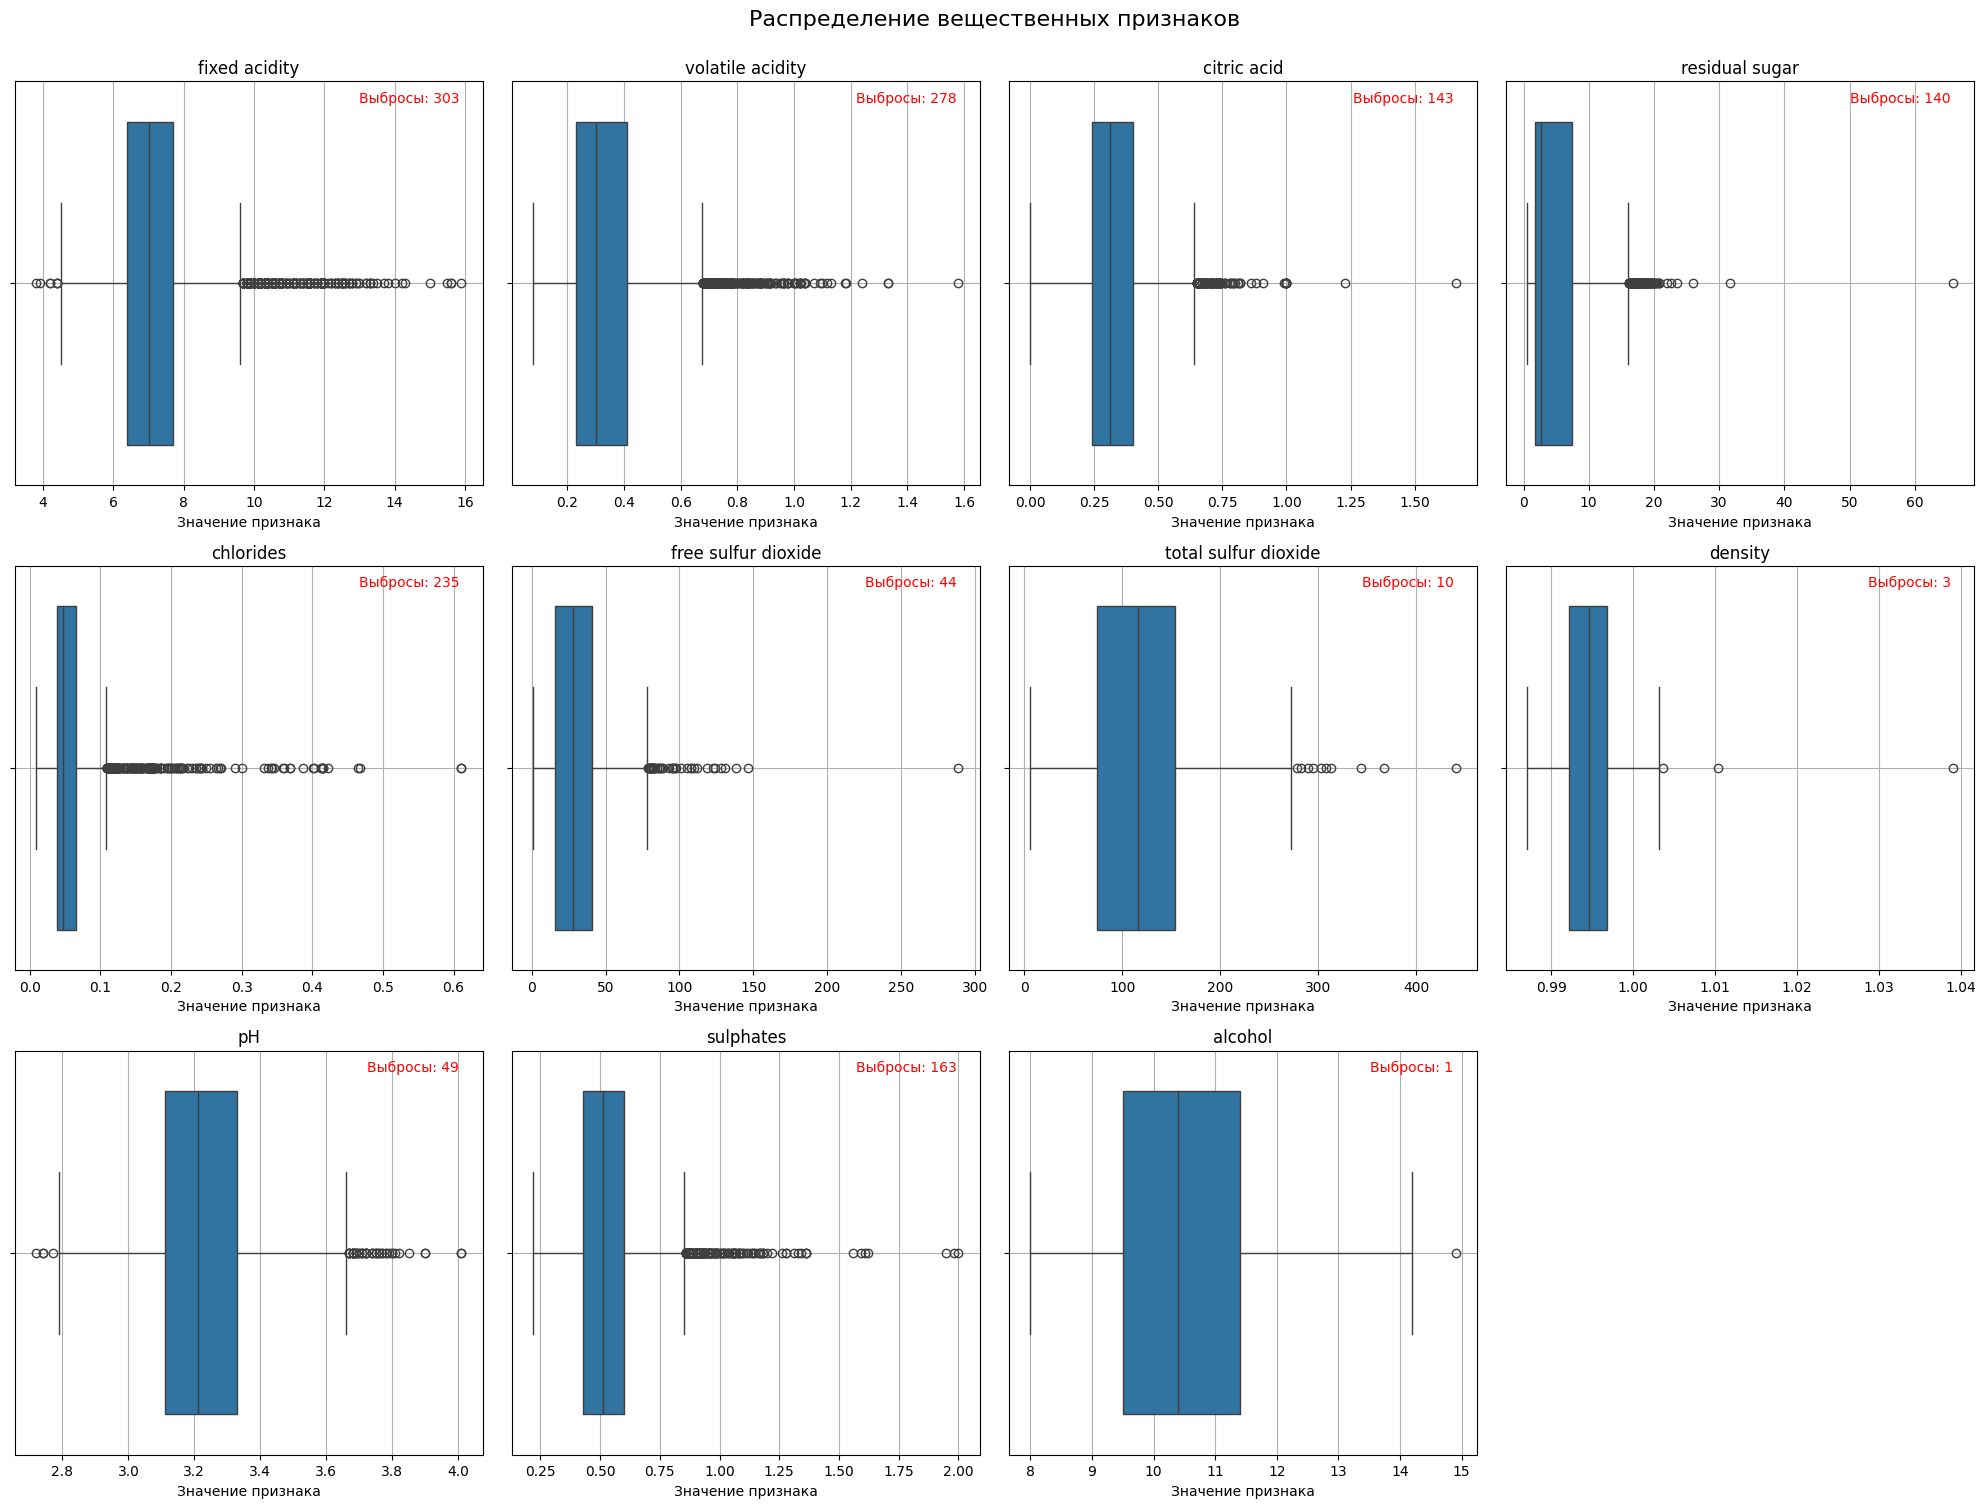

In [15]:
plt.figure(figsize=(20, 27))
plt.suptitle('Распределение вещественных признаков', y=0.9, fontsize=16)

num = 0
for column in df.select_dtypes(include=['float']).columns:
    # считаем количество выбросов
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1 # межквартильный размах
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    num_outliers = len(outliers)

    # смотрим на распределение
    ax = plt.subplot(5, 4, num + 1)
    sns.boxplot(x=df[column], ax=ax)
    ax.set_title(column)
    ax.set_xlabel('Значение признака')
    ax.text(
        0.95,
        0.95,
        f'Выбросы: {num_outliers}',
        fontsize=10,
        color='red',
        ha='right',
        transform=ax.transAxes
    )
    ax.grid()
    num += 1
    print(f'Количество выбросов у признака {column}: {num_outliers}')

plt.tight_layout(rect=[0, 0, 1, 0.9])
# plt.savefig('Распределение вещественных признаков боксплот.png', dpi=300, bbox_inches='tight')
plt.show()

Выбросы есть, но их не очень много относительно общего количества данных. Больше всего выбросов в признаках: fixed acidity, volatile acidity и chlorides

### Анализ категориального признака

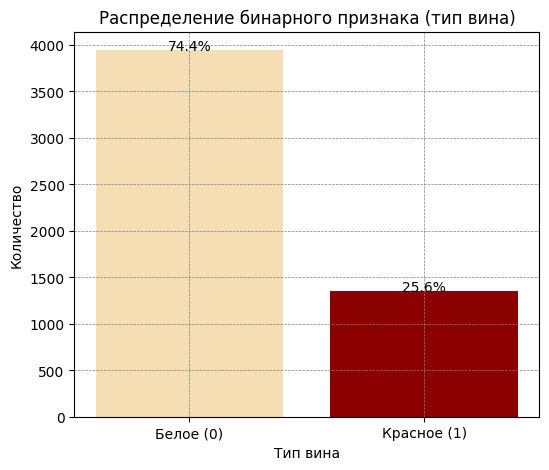

In [16]:
# Вычисление абсолютных и относительных частот
type_counts = df['type'].value_counts()
total = len(df)  # Общее число наблюдений
relative_frequencies = type_counts / total * 100  # Относительные частоты в процентах

plt.figure(figsize=(6, 5))
bars = plt.bar(
    type_counts.index,
    type_counts.values,
    color=['#f5deb3', '#8b0000'],
    tick_label=['Белое (0)', 'Красное (1)']
)

# Добавление подписей с относительными частотами
for bar, freq in zip(bars, relative_frequencies):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f'{freq:.1f}%',
        ha='center',
        fontsize=10
    )

plt.title('Распределение бинарного признака (тип вина)')
plt.xlabel('Тип вина')
plt.ylabel('Количество')
plt.grid(color='gray', linestyle='--', linewidth=0.5);
# plt.savefig('Распределение бинарного признака (тип вина).png', dpi=300, bbox_inches='tight')
plt.show()

Достаточно сильный дисбаланс, надо будет это учесть

Посмотрим на распределение дамми переменной (тип вина) относительно таргета (качество вина)

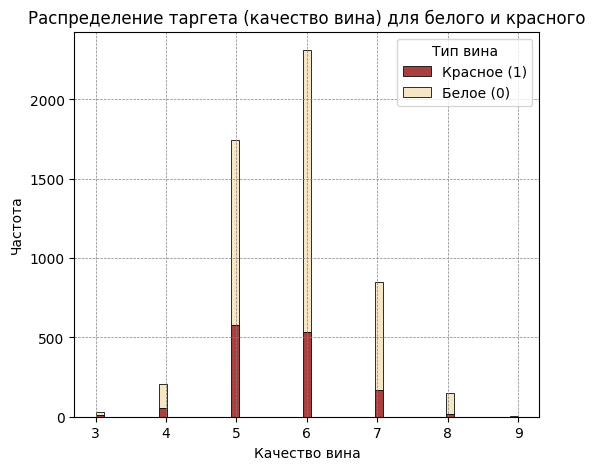

In [17]:
# Построение гистограммы с разделением на белое и красное вино
plt.figure(figsize=(6, 5))
sns.histplot(
    data=df,
    x='quality',
    hue='type',
    multiple='stack',
    palette={0: '#f5deb3', 1: '#8b0000'}
)
plt.title('Распределение таргета (качество вина) для белого и красного')
plt.xlabel('Качество вина')
plt.ylabel('Частота')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.legend(title='Тип вина', labels=['Красное (1)', 'Белое (0)'])
# plt.savefig('Распределение таргета (качество вина) для белого и красного.png', dpi=300, bbox_inches='tight')
plt.show()


In [18]:
relative_frequencies = pd.crosstab(df['quality'], df['type'], normalize='columns')
relative_frequencies.rename(columns={0: 'Белое вино', 1: 'Красное вино'}, inplace=True)

relative_frequencies

type,Белое вино,Красное вино
quality,,
3,0.005074,0.007391
4,0.038559,0.038433
5,0.296550,0.425721
6,0.451547,0.392461
7,0.173770,0.123429
8,0.033232,0.012565
9,0.001268,0.000000


Качество большинства вин (как белого, так и красного) сосредоточено в диапазоне 5–7. Однако белое вино имеет большую долю высоких оценок (7 и выше) относительно своего количества, что может указывать на более высокое качество белого вина в выборке. Красное вино распределено более равномерно по качеству, но с преобладанием среднего уровня (5–6).



### Корреляционный анализ:

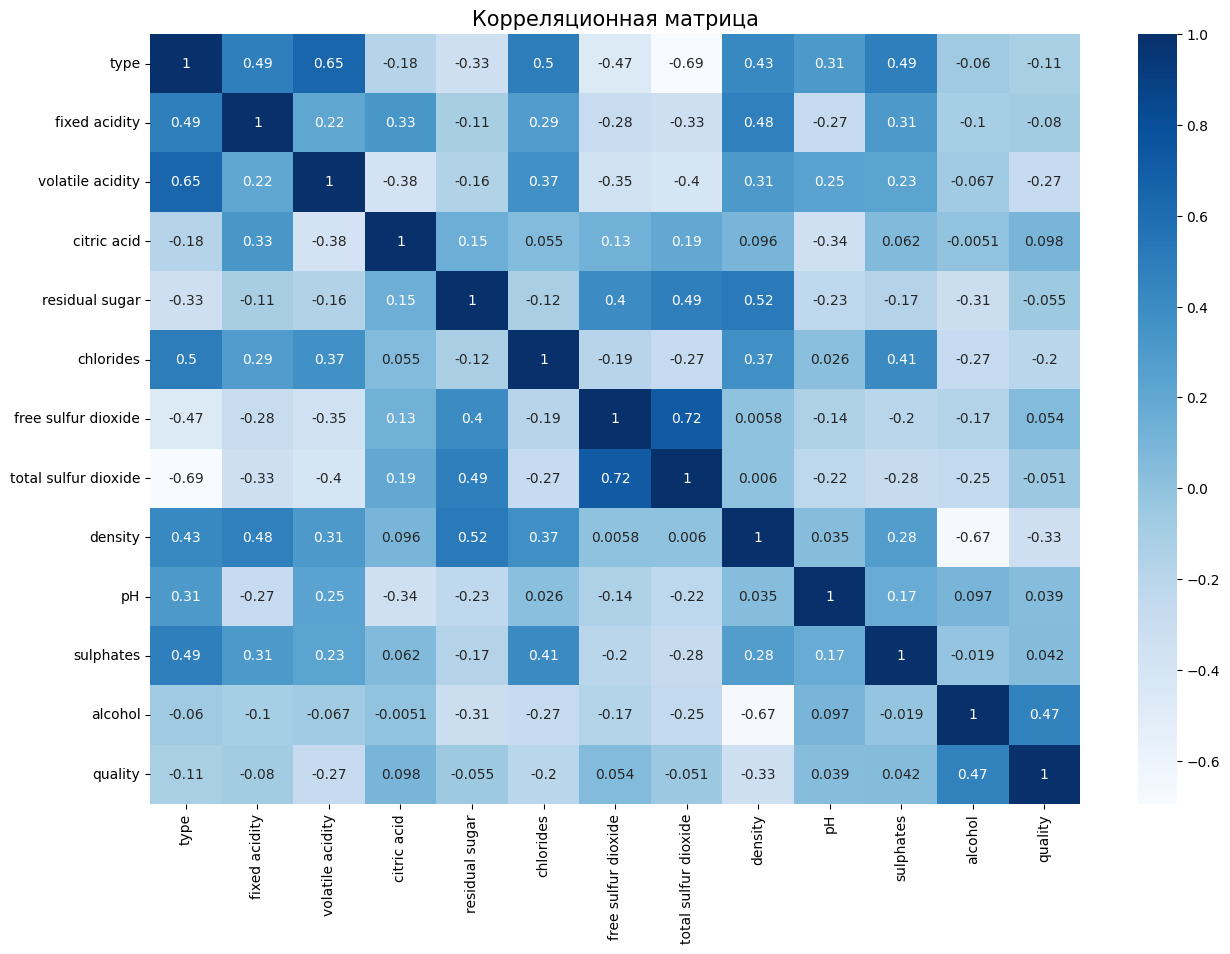

In [19]:
plt.figure(figsize = (15,10))
corr_df = sns.heatmap(df.corr(), cmap='Blues', annot=True, fmt='0.2g')
corr_df.set_title('Корреляционная матрица', fontsize = 15)
# plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

Судя по корреляционной матрице есть проблема мультиколлинеарности:

total sulfur dioxide и free sulfur dioxide: r = 0.72 — сильная корреляция. Это ожидаемо, так как эти признаки связаны химически (общий диоксид серы включает свободный диоксид серы).

density и residual sugar: r = 0.52 — умеренно высокая корреляция.

type и volatile acidity: r = 0.65 — высокая связь.

Постараемся решить эту проблему с помощью удаления или объединения признаков

Теперь проанализируем корреляционные облака с учетом распределения вин на белые и красные:

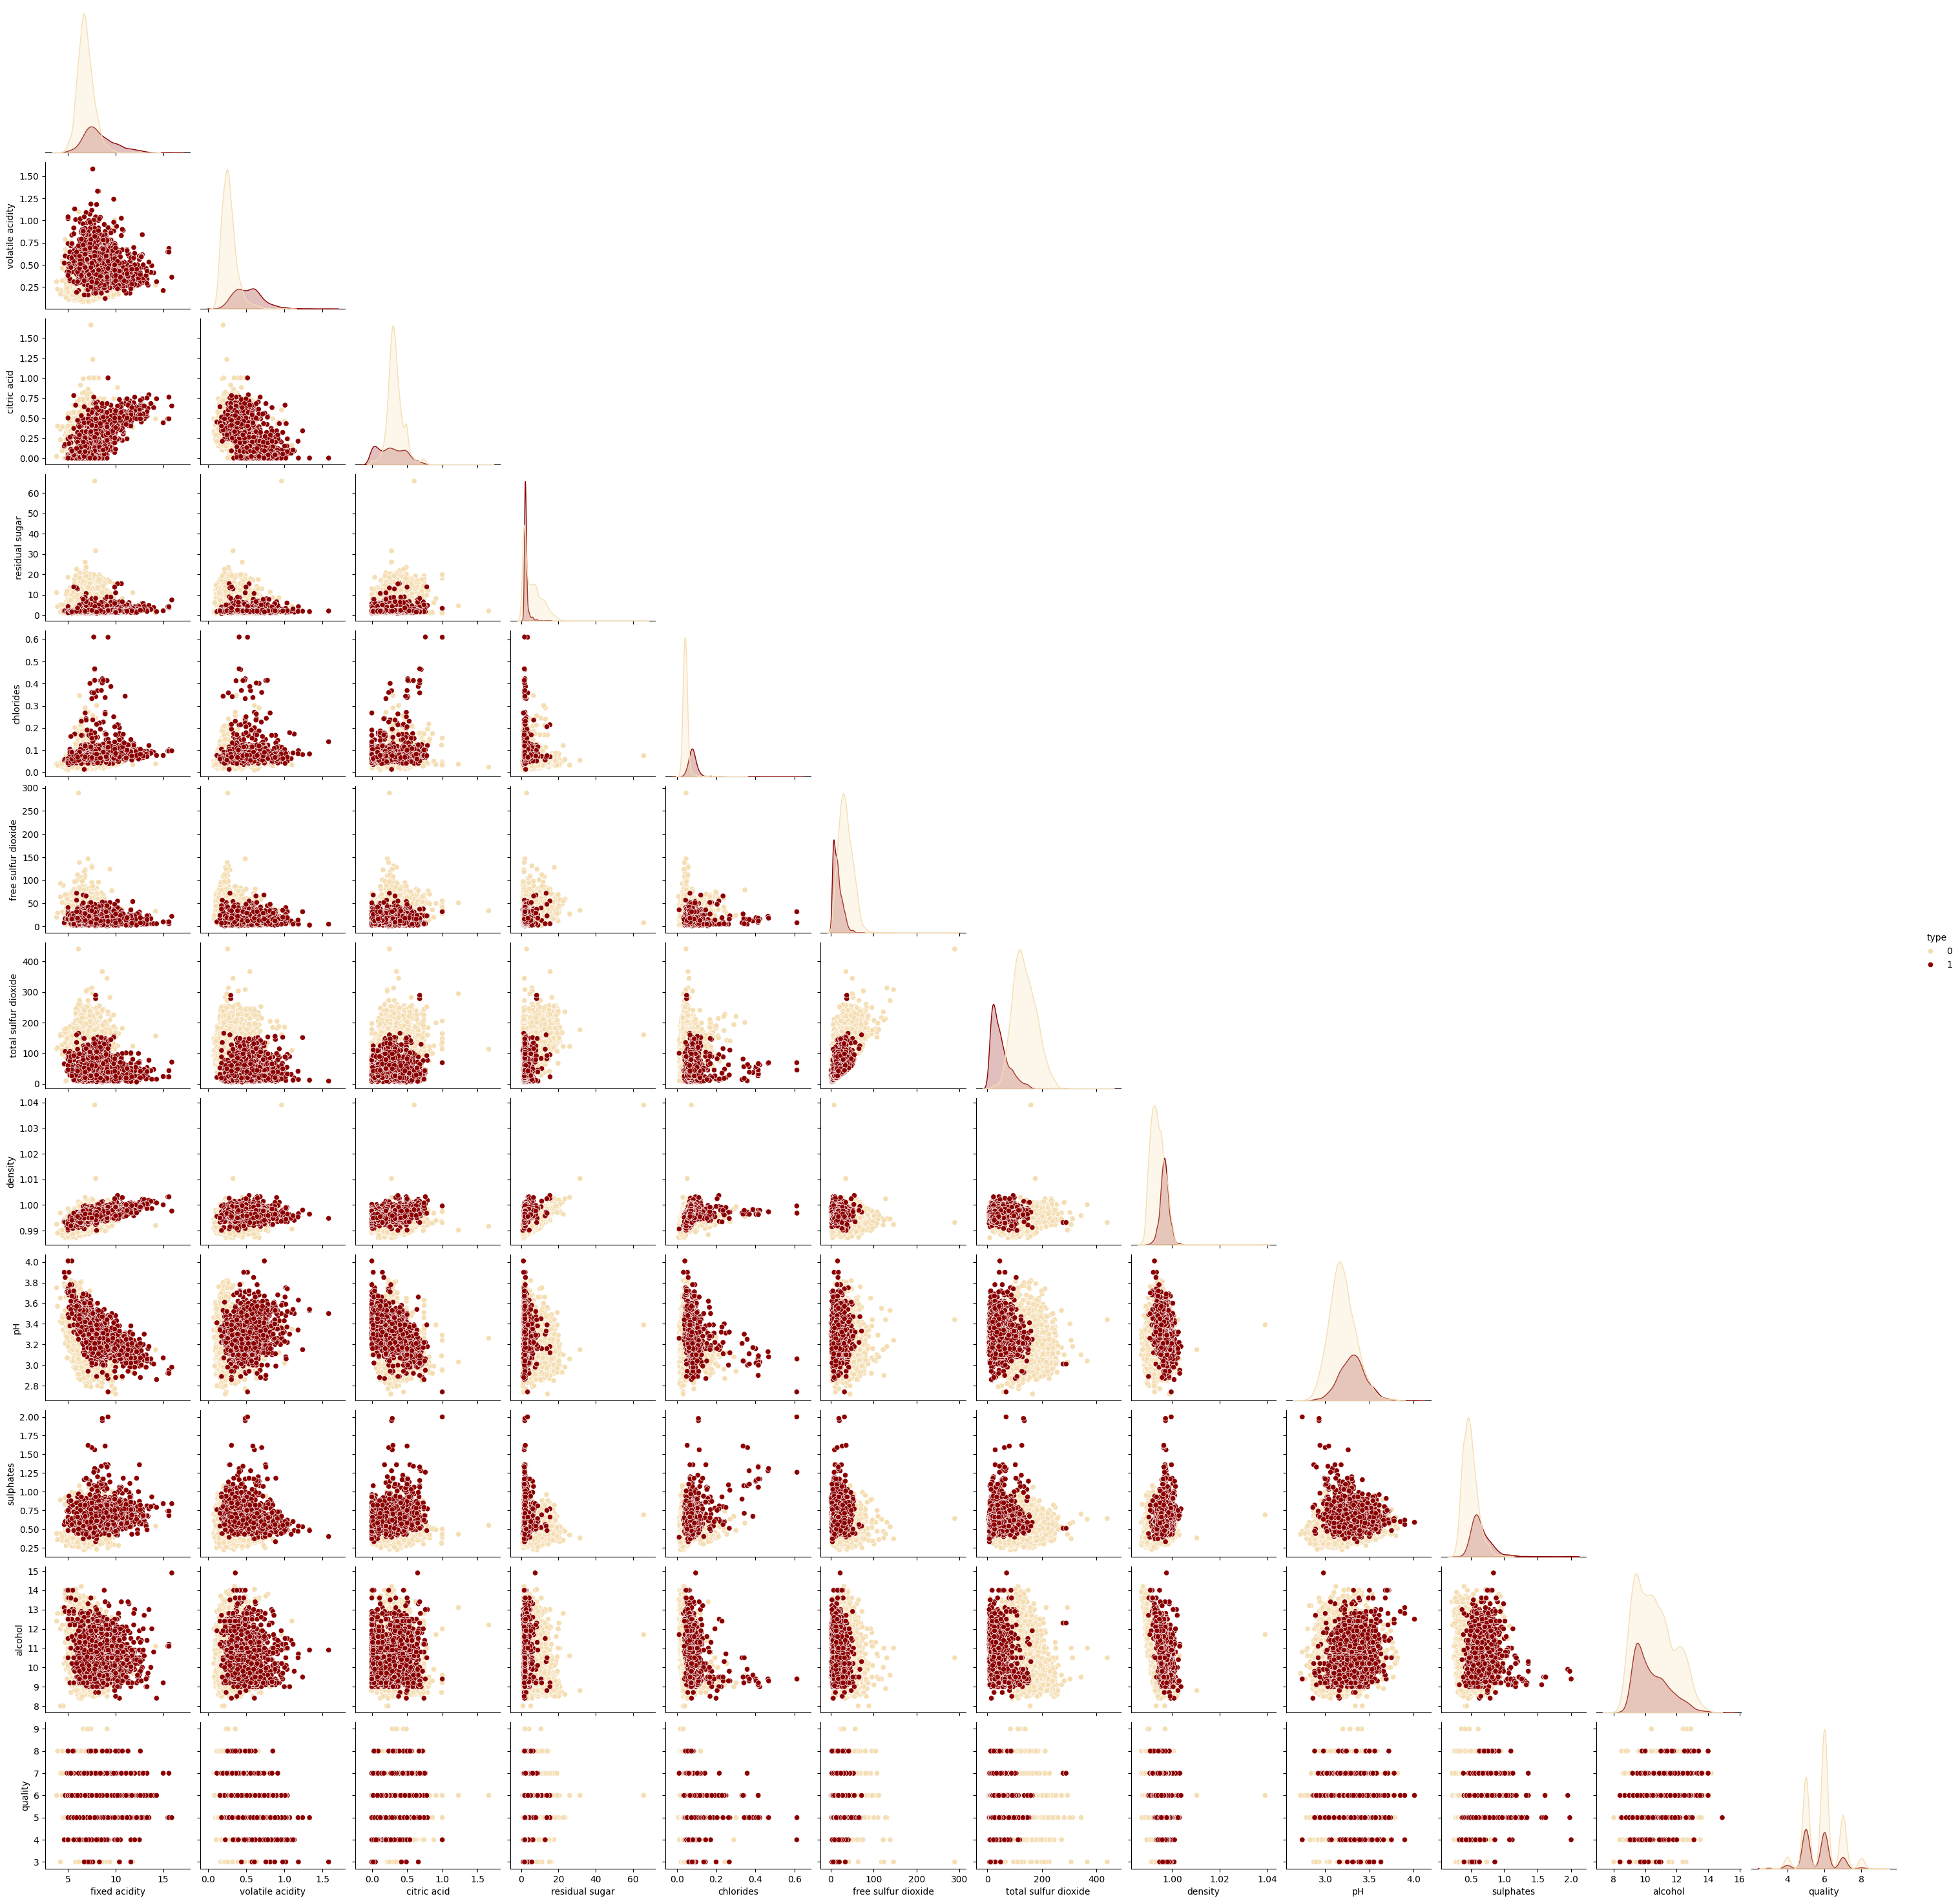

In [20]:
sns.pairplot(
    df,
    diag_kind='kde',
    corner=True,
    hue='type',       # Цветовое выделение по переменной "type"
    palette={0: '#f5deb3', 1: '#8b0000'}
)
# plt.savefig('Корреляционные облака.png', dpi=300, bbox_inches='tight')
plt.show()


1. Действительно заметна корреляция между признаками:
volatile acidity и citric acid - более высокая летучая кислотность связана с низким содержанием лимонной кислоты.
density и residual sugar - вина с более высоким содержанием остаточного сахара имеют большую плотность.
free sulfur dioxide и total sulfur dioxide - с ростом свободного диоксида серы увеличивается общее содержание серы (что логично).
2. Белое и красное вино разделяются по признакам:
volatile acidity (летучая кислотность): красное вино имеет более высокие значения по сравнению с белым.
citric acid (лимонная кислота): белое вино характеризуется более высокими значениями.
residual sugar (остаточный сахар): у белого вина остаточный сахар чаще выше, чем у красного.
density (плотность): белое вино чаще имеет большую плотность, что связано с остаточным сахаром.
3. Качество вина:
Зависимость от alcohol (алкоголь) - Качество вина имеет положительную связь с содержанием алкоголя, особенно заметно для красного вина.
Зависимость от sulphates - У красного вина высокая концентрация сульфатов коррелирует с более высоким качеством.
Разброс quality для type - Красное вино в среднем имеет больший разброс качеств, чем белое, что указывает на более выраженное разнообразие в его характеристиках.

Проверим с помощью теста Чоу, действительно ли надо разделять красное и белое вина при построении модели или их общая модель хорошо описывает обе группы:

H₀ (нулевая гипотеза): Модель одинаково хорошо описывает обе группы.

H₁ (альтернативная гипотеза): Каждая группа лучше описывается своей собственной моделью.

In [21]:
# общая рабивка
y = df['quality']
X = df.drop(columns=['quality'], axis = 1)

# разбивка на белое и красное
red_data = df[df['type'] == 1]
white_data = df[df['type'] == 0]

y_red = red_data['quality']
X_red = red_data.drop(columns=['quality', 'type'], axis = 1)

y_white = white_data['quality']
X_white = white_data.drop(columns=['quality', 'type'], axis = 1)

# добавляем константу
X_red = sm.add_constant(X_red)
X_white = sm.add_constant(X_white)
X = sm.add_constant(X)

# строим модели
model1 = sm.OLS(y_red, X_red).fit()
model2 = sm.OLS(y_white, X_white).fit()
model_full = sm.OLS(y, X).fit()

# Остаточные суммы квадратов
RSS_1 = sum(model1.resid ** 2)
RSS_2 = sum(model2.resid ** 2)
RSS_full = sum(model_full.resid ** 2)

# Степени свободы
k = X_red.shape[1]  # Число параметров (включая константу)
n1, n2 = len(y_red), len(y_white)
n_all = n1 + n2

# F-статистика
numerator = (RSS_full - (RSS_1 + RSS_2)) / k
denominator = (RSS_1 + RSS_2) / (n_all - 2 * k)
F_stat = numerator / denominator

# p-value
p_value = 1 - f.cdf(F_stat, dfn=k, dfd=(n_all - 2 * k))

print(f"Тест Чоу: F-статистика = {F_stat:.4f}, p-value = {p_value:.4f}")


Тест Чоу: F-статистика = 7.7576, p-value = 0.0000


**F-статистика = 7.7576**:
Это значение говорит о том, что модели для двух подгрупп (красное и белое вино) значительно улучшают объяснение данных по сравнению с объединённой моделью.

**p-value = 0.0000** (очень малое значение):
Это значение указывает на статистически значимые различия между моделями для красного и белого вина.
Нулевая гипотеза (о том, что объединённая модель так же хороша, как отдельные) отвергается.

<center>
<img src="https://cdn.nur.kz/images/1200x675/pogudx2dlet41tdf9g.jpeg?version=1" height="300">

</center>

# Обучение моделей

In [22]:
features = df.select_dtypes(include=['float']).columns

# Создание копии датафрейма для стандартизованных данных
df_scaled = df.copy()

# Стандартизация вещественных признаков
scaler = StandardScaler()
df_scaled[features] = scaler.fit_transform(df_scaled[features])

df_scaled.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,-0.165087,-0.440021,0.280208,3.477382,-0.316815,0.838865,0.984149,2.177419,-1.401186,-0.555267,-1.475154,6
1,0,-0.695163,-0.261684,0.144245,-0.766859,-0.208407,-0.900220,0.314921,-0.180598,0.472180,-0.288309,-0.885144,6
2,0,0.667890,-0.380575,0.552136,0.410863,-0.181305,-0.002628,-0.301474,0.189947,0.222398,-0.622007,-0.379421,6
3,0,-0.013636,-0.677803,0.008281,0.766401,0.035512,0.951064,1.265929,0.358377,-0.214721,-0.888964,-0.547996,6
6,0,-0.770888,-0.142793,-1.079428,0.433084,-0.316815,-0.002628,0.385366,0.122576,-0.277166,-0.421788,-0.800857,6


In [23]:
# общая рабивка
y = df_scaled['quality']
X_scaled = df_scaled.drop(columns=['quality'], axis = 1)

# разбивка на белое и красное
red_data_scaled = df_scaled[df_scaled['type'] == 1]
white_data_scaled = df_scaled[df_scaled['type'] == 0]

y_red = red_data_scaled['quality']
X_red_scaled = red_data_scaled.drop(columns=['quality', 'type'], axis = 1)

y_white = white_data_scaled['quality']
X_white_scaled = white_data_scaled.drop(columns=['quality', 'type'], axis = 1)

### Модель для красного вина

In [24]:
# добавим константу
X_red_scaled = sm.add_constant(X_red_scaled)
model_red = sm.OLS(y_red, X_red_scaled).fit()

# Вывод результатов
print("Модель для красного вина:")
print(model_red.summary())

Модель для красного вина:
                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     69.97
Date:                Fri, 13 Dec 2024   Prob (F-statistic):          9.21e-124
Time:                        20:33:39   Log-Likelihood:                -1350.2
No. Observations:                1353   AIC:                             2724.
Df Residuals:                    1341   BIC:                             2787.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const 

In [25]:
# # Извлекаем все таблицы из результатов модели
# summary = model_red.summary()

# # Таблица 1: Общая информация о модели
# table_1 = pd.read_html(summary.tables[0].as_html(), header=None)[0]

# # Таблица 2: Коэффициенты модели
# table_2 = pd.read_html(summary.tables[1].as_html(), header=0, index_col=0)[0]

# # Таблица 3: Прочая информация
# table_3 = pd.read_html(summary.tables[2].as_html(), header=None)[0]

# # Сохранение таблиц в разные листы Excel
# with pd.ExcelWriter('red_tables_1.xlsx') as writer:
#     table_1.to_excel(writer, sheet_name='Summary_Info', index=False)
#     table_2.to_excel(writer, sheet_name='Coefficients')
#     table_3.to_excel(writer, sheet_name='Additional_Info', index=False)

# print("Все три таблицы сохранены в файлы 'model_results_all_tables.xlsx' и отдельные CSV файлы.")


### Модель для белого вина

In [26]:
X_white_scaled = sm.add_constant(X_white_scaled)
model_white = sm.OLS(y_white, X_white_scaled).fit()

print("\nМодель для белого вина:")
print(model_white.summary())


Модель для белого вина:
                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     153.5
Date:                Fri, 13 Dec 2024   Prob (F-statistic):          5.24e-295
Time:                        20:33:39   Log-Likelihood:                -4433.2
No. Observations:                3942   AIC:                             8890.
Df Residuals:                    3930   BIC:                             8966.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const  

In [27]:
# # Извлекаем все таблицы из результатов модели
# summary = model_white.summary()

# # Таблица 1: Общая информация о модели
# table_1 = pd.read_html(summary.tables[0].as_html(), header=None)[0]

# # Таблица 2: Коэффициенты модели
# table_2 = pd.read_html(summary.tables[1].as_html(), header=0, index_col=0)[0]

# # Таблица 3: Прочая информация
# table_3 = pd.read_html(summary.tables[2].as_html(), header=None)[0]

# # Сохранение таблиц в разные листы Excel
# with pd.ExcelWriter('white_tables_1.xlsx') as writer:
#     table_1.to_excel(writer, sheet_name='Summary_Info', index=False)
#     table_2.to_excel(writer, sheet_name='Coefficients')
#     table_3.to_excel(writer, sheet_name='Additional_Info', index=False)

# print("Все три таблицы сохранены в файлы 'model_results_all_tables.xlsx' и отдельные CSV файлы.")

### Общая модель

In [28]:
X_scaled = sm.add_constant(X_scaled)
model = sm.OLS(y, X_scaled).fit()

print("Общая модель:")
print(model.summary())

Общая модель:
                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     199.7
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:33:39   Log-Likelihood:                -5845.3
No. Observations:                5295   AIC:                         1.172e+04
Df Residuals:                    5282   BIC:                         1.180e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const             

In [29]:
# # Извлекаем все таблицы из результатов модели
# summary = model.summary()

# # Таблица 1: Общая информация о модели
# table_1 = pd.read_html(summary.tables[0].as_html(), header=None)[0]

# # Таблица 2: Коэффициенты модели
# table_2 = pd.read_html(summary.tables[1].as_html(), header=0, index_col=0)[0]

# # Таблица 3: Прочая информация
# table_3 = pd.read_html(summary.tables[2].as_html(), header=None)[0]

# # Сохранение таблиц в разные листы Excel
# with pd.ExcelWriter('all_tables_1.xlsx') as writer:
#     table_1.to_excel(writer, sheet_name='Summary_Info', index=False)
#     table_2.to_excel(writer, sheet_name='Coefficients')
#     table_3.to_excel(writer, sheet_name='Additional_Info', index=False)

# print("Все три таблицы сохранены в файлы 'model_results_all_tables.xlsx' и отдельные CSV файлы.")

<center>
<img src="https://sun9-73.userapi.com/impf/c830608/v830608474/1a4a33/iOdL1ZxYS_c.jpg?size=1280x631&quality=96&sign=46e752dd03bbf58b0149cd0d45f199d7&c_uniq_tag=tVJghzsZiLrtu5m27KwcM8mYOKJqsX7ZrL1daJtbIzw&type=album" height="400">

</center>

## Борьба с мультиколлинеарностью

Добавим новые переменные, которые связывают сильно коррелированные признаки:




In [30]:
df_scaled['sulfur_dioxide_ratio'] = df_scaled['free sulfur dioxide'] / df_scaled['total sulfur dioxide']
df_scaled['acidity_density'] = df_scaled['fixed acidity'] * df_scaled['density']
# df_scaled['alcohol_density'] = df_scaled['alcohol'] * df_scaled['density']
# df_scaled['volatile_citric_diff'] = df_scaled['volatile acidity'] - df_scaled['citric acid']
# # df['chlorides_sugar'] = df['chlorides'] * df['residual sugar']
# df_scaled['type_alcohol'] = df['type'] * df_scaled['alcohol']
# df_scaled['type_density'] = df['type'] * df_scaled['density']
# df_scaled['alcohol_acidity_sulphates'] = df_scaled['alcohol'] * df_scaled['volatile acidity'] * df_scaled['sulphates']
# df_scaled['weighted_sulfur_chlorides'] = (df_scaled['free sulfur dioxide'] + df_scaled['total sulfur dioxide']) / df_scaled['chlorides']


In [31]:
# общая рабивка
y = df_scaled['quality']
X_scaled = df_scaled.drop(columns=['quality'], axis = 1)

# разбивка на белое и красное
red_data_scaled = df_scaled[df_scaled['type'] == 1]
white_data_scaled = df_scaled[df_scaled['type'] == 0]

y_red = red_data_scaled['quality']
X_red_scaled = red_data_scaled.drop(columns=['quality', 'type'], axis = 1)

y_white = white_data_scaled['quality']
X_white_scaled = white_data_scaled.drop(columns=['quality', 'type'], axis = 1)

### Модель для красного вина

In [32]:
# добавим константу
X_red_scaled = sm.add_constant(X_red_scaled)
model_red = sm.OLS(y_red, X_red_scaled).fit()

# Вывод результатов
print("Модель для красного вина:")
print(model_red.summary())

Модель для красного вина:
                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     59.43
Date:                Fri, 13 Dec 2024   Prob (F-statistic):          1.75e-122
Time:                        20:33:39   Log-Likelihood:                -1348.9
No. Observations:                1353   AIC:                             2726.
Df Residuals:                    1339   BIC:                             2799.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const 

### Модель для белого вина

In [33]:
X_white_scaled = sm.add_constant(X_white_scaled)
model_white = sm.OLS(y_white, X_white_scaled).fit()

print("\nМодель для белого вина:")
print(model_white.summary())


Модель для белого вина:
                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     130.7
Date:                Fri, 13 Dec 2024   Prob (F-statistic):          1.68e-294
Time:                        20:33:39   Log-Likelihood:                -4429.3
No. Observations:                3942   AIC:                             8887.
Df Residuals:                    3928   BIC:                             8975.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const  

<center>
<img src="https://www.meme-arsenal.com/memes/f8cc5de0481adf8f19e4979d5b275d3a.jpg" height="400">

</center>